In [5]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

###############################################################################
# 1) Meal / Snack Classification
###############################################################################
def classify_event(event, meals, snacks, mega_meals,
                   hourly_meals, hourly_snacks, hourly_mega_meals):
    """
    'event' is a contiguous cluster of pellet times (already offset so earliest is 0).
    day_index = int(event[0]//24), hour = int(event[0]%24).
    If day_index < 7 => increment one of the 7x24 counters.
    """
    size = len(event)
    day_index = int(event[0] // 24)
    hour = int(event[0] % 24)

    if size == 1:
        snacks.append(event)
        if 0 <= day_index < 7:
            hourly_snacks[day_index][hour] += 1
    elif 2 <= size <= 5:
        meals.append(event)
        if 0 <= day_index < 7:
            hourly_meals[day_index][hour] += 1
    else:
        mega_meals.append(event)
        if 0 <= day_index < 7:
            hourly_mega_meals[day_index][hour] += 1


def compute_metrics(meals, snacks, mega_meals, period,
                    hourly_meals, hourly_snacks, hourly_mega_meals):
    """
    Summarizes the cluster data into 15 metrics (meal_size, snack_size, etc.).
    """
    meal_size = (sum(len(m) for m in meals) / len(meals)) if meals else 0
    snack_size = (sum(len(s) for s in snacks) / len(snacks)) if snacks else 0

    number_of_meals = len(meals)
    meal_frequency = (number_of_meals / period) if period else 0

    number_of_snacks = len(snacks)
    snack_frequency = (number_of_snacks / period) if period else 0

    mega_meal_frequency = (len(mega_meals) / period) if period else 0
    mega_meal_size = ((sum(len(m) for m in mega_meals) / len(mega_meals))
                      if mega_meals else 0)

    number_of_mega_meals = len(mega_meals)

    return [
        meal_size,               # 0
        snack_size,              # 1
        number_of_meals,         # 2
        meal_frequency,          # 3
        number_of_snacks,        # 4
        snack_frequency,         # 5
        mega_meal_frequency,     # 6
        mega_meal_size,          # 7
        hourly_meals,            # 8
        hourly_snacks,           # 9
        hourly_mega_meals,       #10
        meals,                   #11
        snacks,                  #12
        mega_meals,              #13
        number_of_mega_meals     #14
    ]


def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    """
    1) Sort times
    2) Offset them so that the earliest pellet is at 0.0 hours
    3) Group contiguous pellets (IPI <= meal_threshold)
    4) Classify each cluster (snack/meal/mega)
    5) Return 15 metrics
    """
    if not pellettimes:
        return [0]*15

    pellettimes = sorted(pellettimes)
    # --- NEW: SHIFT EPOCH TIMES so earliest becomes 0. ---
    offset = pellettimes[0]
    pellettimes = [t - offset for t in pellettimes]

    IPIs = np.diff(np.array(pellettimes))

    meals, snacks, mega_meals = [], [], []
    hourly_meals = [[0]*24 for _ in range(7)]
    hourly_snacks = [[0]*24 for _ in range(7)]
    hourly_mega_meals = [[0]*24 for _ in range(7)]

    current_cluster = [pellettimes[0]]
    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_cluster.append(pellettimes[i+1])
        else:
            classify_event(current_cluster, meals, snacks, mega_meals,
                           hourly_meals, hourly_snacks, hourly_mega_meals)
            current_cluster = [pellettimes[i+1]]
    # Final cluster
    classify_event(current_cluster, meals, snacks, mega_meals,
                   hourly_meals, hourly_snacks, hourly_mega_meals)

    # The total observation period is last - first
    # But after offset, the first is 0, so total period is pellettimes[-1]
    total_obs_period = pellettimes[-1] - pellettimes[0]
    if total_obs_period <= 0:
        total_obs_period = 1  # to avoid div-by-zero

    return compute_metrics(meals, snacks, mega_meals, total_obs_period,
                           hourly_meals, hourly_snacks, hourly_mega_meals)


def get_events_per_day(events, days):
    """
    Given event clusters with times already offset so earliest pellet = 0,
    day=0 => times in [0..24), day=1 => [24..48), ...
    We'll just check event[0] for the cluster start day.
    """
    events_per_day = [0]*days
    for cluster in events:
        if len(cluster) > 0:
            day_idx = int(cluster[0] // 24)
            if 0 <= day_idx < days:
                events_per_day[day_idx] += 1
    return events_per_day


def get_pellets_per_day(timestamps, days):
    """
    times are offset so earliest pellet=0.
    For day=0..days-1, we count how many pellets fall in [day*24..(day+1)*24).
    """
    pellets_per_day = [0]*days
    for t in timestamps:
        day_idx = int(t // 24)
        if 0 <= day_idx < days:
            pellets_per_day[day_idx] += 1
    return pellets_per_day

###############################################################################
# 2) Reading the CSV / Creating epoch-level lists of pellet times
#    NOTE: This function does NOT offset anything. That offset is done inside
#    get_meal_and_snack_metrics. So we can simply store the raw global times.
###############################################################################
def get_FEDevents(filename, eventname="Pellet"):
    """
    Original approach: parse each row, check row[7]==eventname,
    convert the date/time to hours from the *first row's 07:00* (NOT global).
    We'll keep that for single-file consistency. But to fix the day-by-day = 0 problem,
    we do the offset in get_meal_and_snack_metrics.
    """
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']

    try:
        file = open(filename, 'r')
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = list(csvreader)

    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Auto-detect datetime format
    try:
        datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        date_format = formats[1]

    # The old code picks the reference point from the *first row's date* + "07:00:00"
    # We'll keep that, so E1 might start near 0, E2 might start near 216 hours, etc.
    first_date_str = rows[0][0].split()[0] + " 07:00:00"
    refpoint = datetime.strptime(first_date_str, date_format)

    timestamps = []
    for row in rows:
        if row[7] == eventname:
            dt = datetime.strptime(row[0], date_format)
            pellethours = (dt - refpoint).total_seconds()/3600.0
            timestamps.append(pellethours)

    file.close()
    return sorted(timestamps)

###############################################################################
# 3) Process the METAFILE for E1..E4, each with a known # of days [9,7,7,7],
#    compute the 15 metrics, store them in 'mice' dict, and save to CSV.
###############################################################################
def process_metafile(metafile):
    rows, _ = tp.metafilereader(metafile, sheetname="METAFILE")
    mice = {}

    for row in rows:
        fedfile = row[0]    # filename
        mouse_id = row[1]   # e.g. 'MouseA'
        sex = row[4]
        order_ = row[5]
        epoch = row[6]      # e.g. 'E1','E2',...

        if mouse_id not in mice:
            mice[mouse_id] = {"sex": sex, "order": order_}
        epoch_key = f"epoch_{epoch}"

        # Read raw pellet times
        fname = f"../data/{fedfile}"
        pellettimes = get_FEDevents(fname, "Pellet")
        mice[mouse_id][epoch_key] = pellettimes

    # For each mouse, for each epoch -> compute metrics
    for mouse, info in mice.items():
        # E1=9 days, E2=7, E3=7, E4=7
        for epoch, days in zip(["E1","E2","E3","E4"], [9,7,7,7]):
            epoch_key = f"epoch_{epoch}"
            times = info.get(epoch_key, [])

            metrics = get_meal_and_snack_metrics(times)
            (meal_size, snack_size,
             number_of_meals, meal_frequency,
             number_of_snacks, snack_frequency,
             mega_meal_frequency, mega_meal_size,
             hourly_meals, hourly_snacks, hourly_mega_meals,
             raw_meals, raw_snacks, raw_mega_meals,
             number_of_mega_meals) = metrics

            info[f"{epoch_key}_meal_size"] = meal_size
            info[f"{epoch_key}_snack_size"] = snack_size
            info[f"{epoch_key}_number_of_meals"] = number_of_meals
            info[f"{epoch_key}_meal_frequency"] = meal_frequency
            info[f"{epoch_key}_number_of_snacks"] = number_of_snacks
            info[f"{epoch_key}_snack_frequency"] = snack_frequency
            info[f"{epoch_key}_mega_meal_frequency"] = mega_meal_frequency
            info[f"{epoch_key}_mega_meal_size"] = mega_meal_size
            info[f"{epoch_key}_number_of_mega_meals"] = number_of_mega_meals

            # Day-by-day
            # We also pass the *already offset times*, i.e. the same offset used in the classification
            # So let's do that by re-using the offset step:
            if times:
                tmin = min(times)
                offset_times = [t - tmin for t in times]
            else:
                offset_times = []

            info[f"{epoch_key}_pellets_per_day"] = get_pellets_per_day(offset_times, days)
            info[f"{epoch_key}_meals_per_day"]   = get_events_per_day(raw_meals, days)
            info[f"{epoch_key}_snacks_per_day"]  = get_events_per_day(raw_snacks, days)
            info[f"{epoch_key}_mega_meals_per_day"] = get_events_per_day(raw_mega_meals, days)

    return mice


if __name__ == "__main__":
    metafile_path = "../FEDXC_METAFILE.csv"
    mice_data = process_metafile(metafile_path)

    # Save everything to CSV
    output_file = "epoch_analysis_results_FIXED.csv"
    fieldnames = (
        ["mouse_id","sex","order"] +
        [f"epoch_{ep}_{met}"
         for ep in ["E1","E2","E3","E4"]
         for met in ["meal_size","snack_size","number_of_meals","meal_frequency",
                     "number_of_snacks","snack_frequency","mega_meal_frequency",
                     "mega_meal_size","number_of_mega_meals",
                     "pellets_per_day","meals_per_day","snacks_per_day","mega_meals_per_day"]]
    )

    with open(output_file,"w",newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for mouse_id, info in mice_data.items():
            row = {
                "mouse_id": mouse_id,
                "sex": info["sex"],
                "order": info["order"]
            }
            for ep in ["E1","E2","E3","E4"]:
                ep_key = f"epoch_{ep}"
                for met in ["meal_size","snack_size","number_of_meals","meal_frequency",
                            "number_of_snacks","snack_frequency","mega_meal_frequency",
                            "mega_meal_size","number_of_mega_meals",
                            "pellets_per_day","meals_per_day","snacks_per_day","mega_meals_per_day"]:
                    row[f"{ep_key}_{met}"] = info.get(f"{ep_key}_{met}", 0)
            writer.writerow(row)

    print(f"Saved new file: {output_file}")


Saved new file: epoch_analysis_results_FIXED.csv


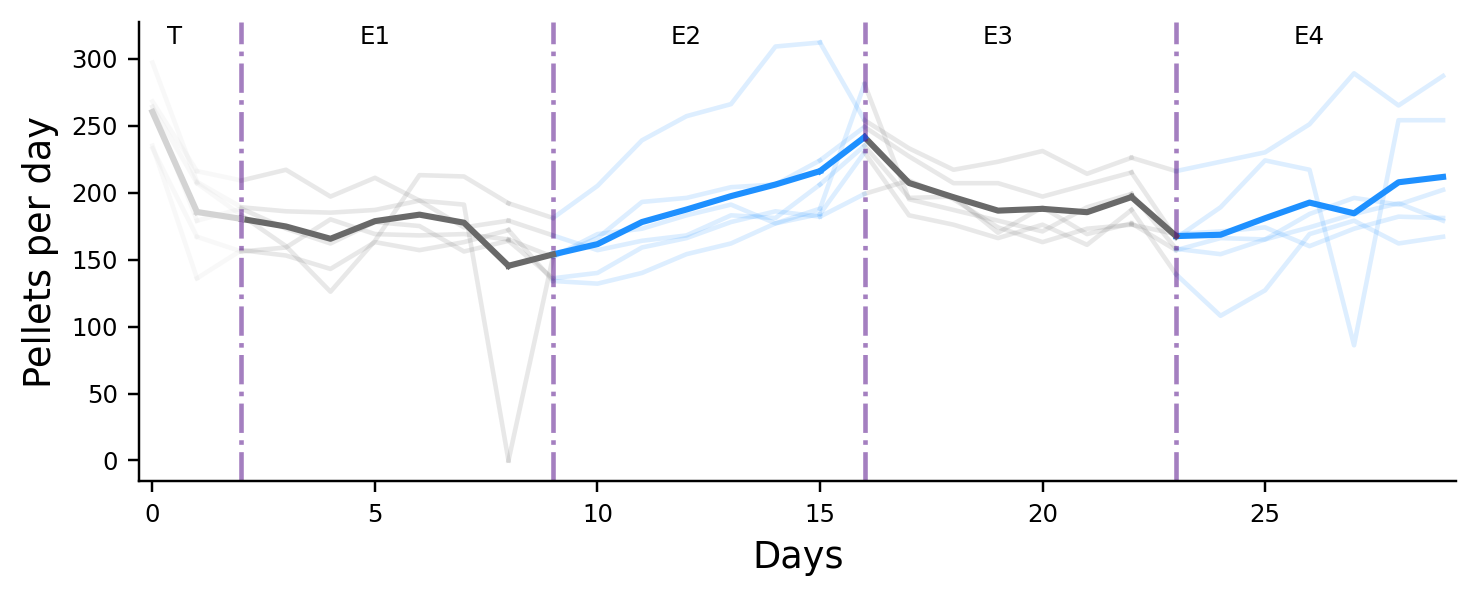

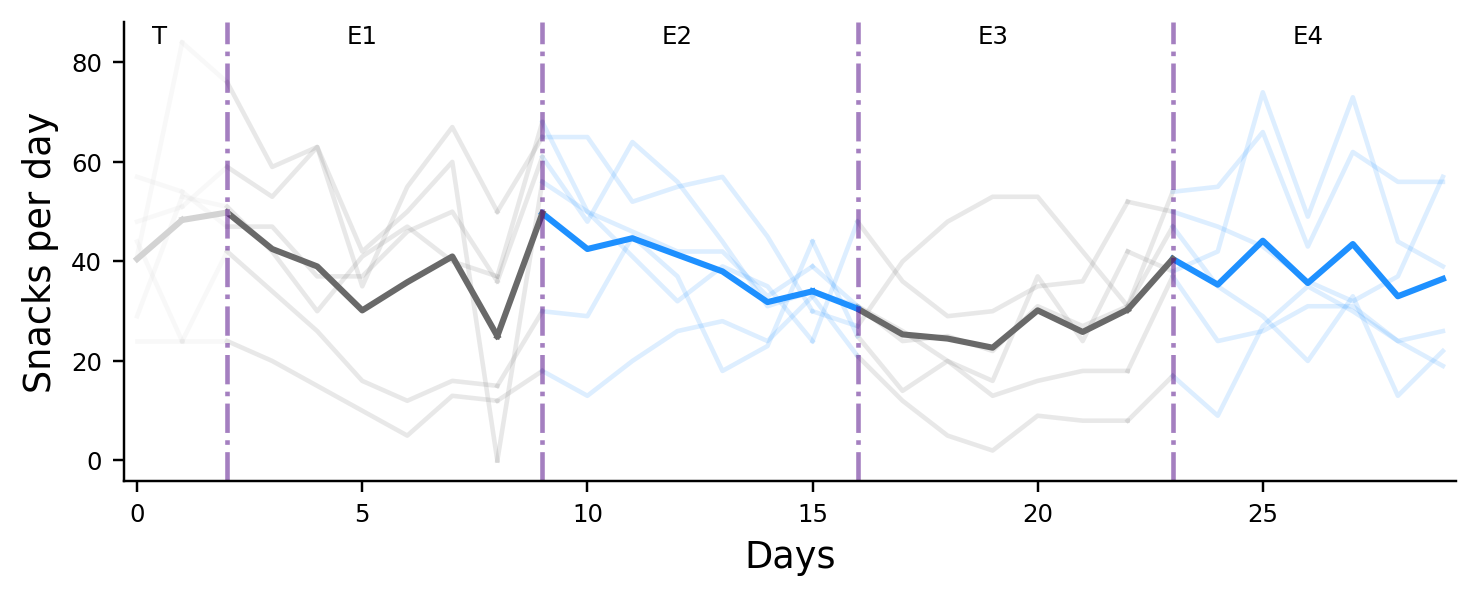

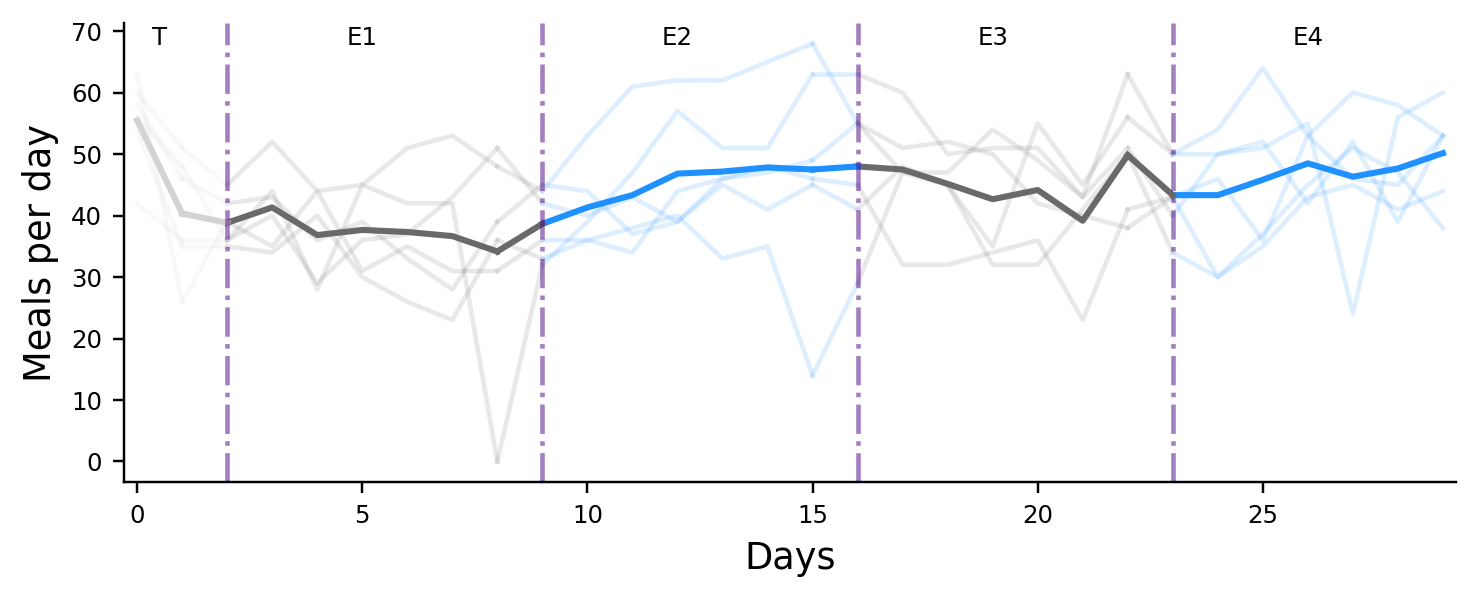

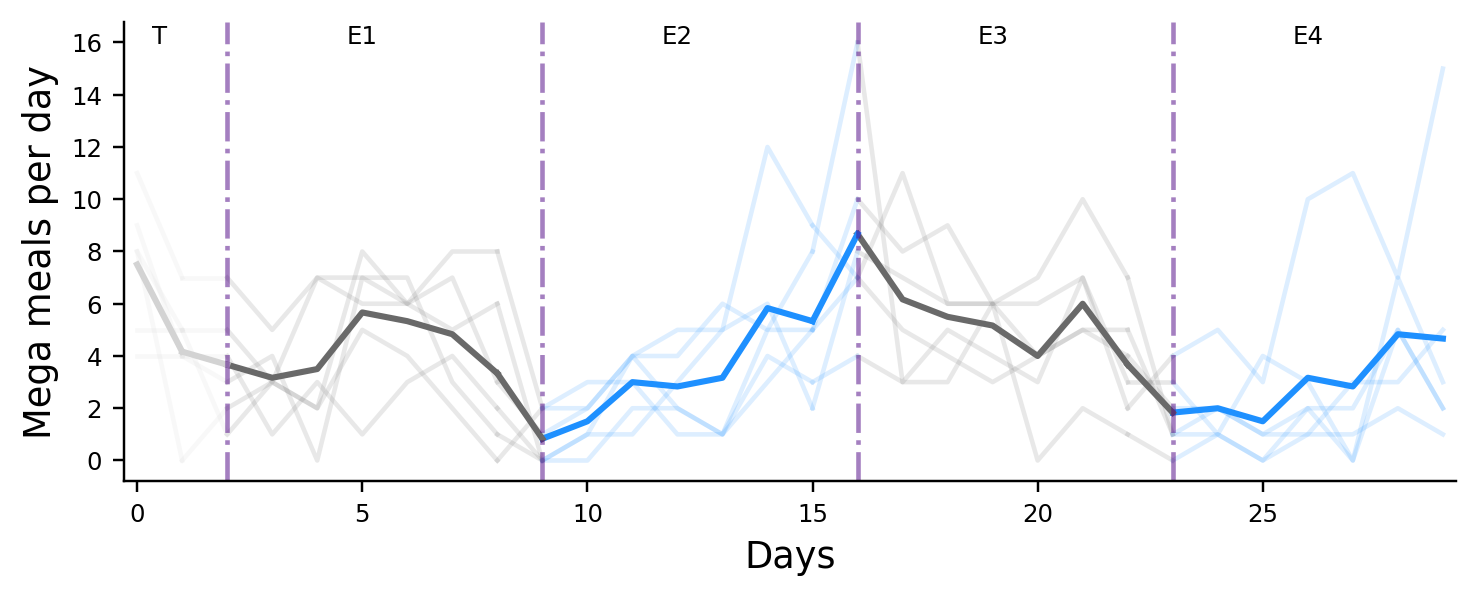

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

# -----------------------------
# 1. Load CSV and Filter for Order 2
# -----------------------------
csv_path = "epoch_analysis_results_FIXED(LINE).csv"
df = pd.read_csv(csv_path)
df_order2 = df[df["order"] == 2].copy()

# -----------------------------
# 2. Convert Per-Day Columns to Lists
# -----------------------------
def convert_to_list(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except:
        return []

metrics = ["pellets_per_day", "snacks_per_day", "meals_per_day", "mega_meals_per_day"]
epochs = ["E1", "E2", "E3", "E4"]

for epoch in epochs:
    for metric in metrics:
        col = f"epoch_{epoch}_{metric}"
        if col in df_order2.columns:
            df_order2[col] = df_order2[col].apply(convert_to_list)

# -----------------------------
# 3. Build Continuous Timeline for Each Metric
# -----------------------------
# E1 = 9 days (0–8); first 2 days (0–1) = training
# E2, E3, E4 = 7 days each => total 30 days (0–29)
def build_trace(row, metric):
    trace = []
    for epoch in epochs:
        col = f"epoch_{epoch}_{metric}"
        daily_vals = row.get(col, [])
        trace += daily_vals
    # Ensure we have exactly 30 days
    if len(trace) < 30:
        trace += [0]*(30-len(trace))
    return trace[:30]

order2_traces = {metric: [] for metric in metrics}

for _, row in df_order2.iterrows():
    for metric in metrics:
        day_by_day = build_trace(row, metric)
        order2_traces[metric].append(day_by_day)

for metric in metrics:
    order2_traces[metric] = np.array(order2_traces[metric])  # shape: (n_mice, 30)

# -----------------------------
# 4. Plotting Setup & Timeline (Order 2 Only)
# -----------------------------
# Segments:
#   Training = days 0–1 -> (0,2)
#   E1 = days 2–8       -> (2,9)
#   E2 = days 9–15      -> (9,16)
#   E3 = days 16–22     -> (16,23)
#   E4 = days 23–29     -> (23,30)
segments = [(0, 2), (2, 9), (9, 16), (16, 23), (23, 30)]
segment_labels = ["T", "E1", "E2", "E3", "E4"]

# Keep your original color pattern
segment_colors = ["lightgray", "dimgray", "dodgerblue", "dimgray", "dodgerblue"]

total_days = 30
ylabels = {
    "pellets_per_day": "Pellets per day",
    "snacks_per_day":  "Snacks per day",
    "meals_per_day":   "Meals per day",
    "mega_meals_per_day": "Mega meals per day"
}

for metric in metrics:
    data = order2_traces[metric]  # shape: (n_mice, 30)
    n_mice = data.shape[0]
    
    fig, ax = plt.subplots(figsize=(7, 3), dpi=220)
    
    # Plot each mouse's trace, segment-by-segment
    for i in range(n_mice):
        trace = data[i, :]
        for seg_idx, (start, end) in enumerate(segments):
            x_seg = np.arange(start, end)
            y_seg = trace[start:end]
            # Each segment in the color for that segment
            ax.plot(x_seg, y_seg, color=segment_colors[seg_idx], linestyle='-', alpha=0.15)
        # Connect boundaries with the color of the CURRENT segment
        for seg_idx in range(len(segments) - 1):
            boundary = segments[seg_idx][1]  # e.g. 2 -> 9 -> 16 -> 23
            if boundary - 1 < len(trace) and boundary < len(trace):
                x_connect = [boundary - 1, boundary]
                y_connect = [trace[boundary - 1], trace[boundary]]
                # Use the color of the current segment (seg_idx),
                # not seg_idx+1
                ax.plot(x_connect, y_connect, color=segment_colors[seg_idx], linestyle='-', alpha=0.15)
    
    # Overplot the mean trace in thicker lines
    mean_trace = np.nanmean(data, axis=0)
    for seg_idx, (start, end) in enumerate(segments):
        x_seg = np.arange(start, end)
        y_seg = mean_trace[start:end]
        ax.plot(x_seg, y_seg, color=segment_colors[seg_idx], linewidth=2)
    # Connect boundaries of the mean trace w/ the current segment color
    for seg_idx in range(len(segments) - 1):
        boundary = segments[seg_idx][1]
        if boundary - 1 < len(mean_trace) and boundary < len(mean_trace):
            x_connect = [boundary - 1, boundary]
            y_connect = [mean_trace[boundary - 1], mean_trace[boundary]]
            ax.plot(x_connect, y_connect, color=segment_colors[seg_idx], linewidth=2)
    
    # Vertical dashed lines at segment boundaries
    for boundary in [2, 9, 16, 23]:
        ax.axvline(boundary, linestyle='-.', color='indigo', alpha=0.5)
    
    # Segment labels (midpoints) near top
    y_top = ax.get_ylim()[1]
    for seg_idx, (start, end) in enumerate(segments):
        mid = (start + end - 1) / 2
        ax.text(mid, 0.95 * y_top, segment_labels[seg_idx], ha='center', fontsize=8)
    
    # X / Y labels and ticks
    ax.set_xlabel("Days", fontsize=12)
    ax.set_ylabel(ylabels[metric], fontsize=12)
    ax.set_xticks(range(0, total_days+1, 5))
    ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce tick size
    
    # Tiny gap on left/right
    ax.set_xlim(-0.3, 29.3)
    
    # Style: remove top/right spines, no grid
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    # Save if desired
    # fig.savefig(f"line_plot_{metric}_order2.png", bbox_inches='tight', dpi=220)
